In [116]:
import pandas as pd 
import numpy as np 
import glob
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer

# Differnt types of Naive Bayes Classifiers
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB

pd.set_option('display.max_columns', None)

In [6]:
train_path = max(glob.glob('./data/train/*.csv'), key=os.path.getctime) 
df = pd.read_csv(train_path)

In [7]:
to_drop = ['rewards', 'deadline', 'launched_at', 'rewards_processed',
           'description_processed', 'description_story_processed','description_risks_processed',
           'id', 'name', 'description', 'description_story', 'description_risks', 'video', 'pledged', 'state']
to_drop_more = to_drop + ['staff_pick', 'spotlight', 'backers_count', 'update_count', 'faq_count']
to_drop_specific = to_drop_more + ['all_reward_amount']
X_train, y_train = df.drop(to_drop_specific, axis=1), df['state']

In [8]:
#pd.set_option('display.max_columns', None)
X_train.head()

,reward_tiers,category,goal,location,has_video,rewards_0,rewards_1,rewards_2,rewards_3,rewards_4,...,x0_technology/web,x0_theater/comedy,x0_theater/experimental,x0_theater/immersive,x0_theater/musical,x0_theater/plays,"x0_Orchard, Singapore","x0_Queenstown, Singapore","x0_Sembawang, Singapore","x0_Singapore, Singapore"
0,4,technology,800,"Singapore, Singapore",1,0.0,0.0,0.0,0.067220,0.085809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9,design/graphic design,1200,"Singapore, Singapore",0,0.0,0.0,0.0,0.075712,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5,crafts/pottery,100,"Singapore, Singapore",0,0.0,0.0,0.0,0.066717,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7,technology/gadgets,3000,"Singapore, Singapore",1,0.0,0.0,0.0,0.025238,0.032217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,25,design/product design,30000,"Singapore, Singapore",1,0.0,0.0,0.0,0.140152,0.019879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
test_path = max(glob.glob('./data/test/*.csv'), key=os.path.getctime) 
test = pd.read_csv(test_path)
X_test, y_test = test.drop(to_drop_specific, axis=1), test['state']

In [10]:
X_test.head()

,reward_tiers,category,goal,location,has_video,rewards_0,rewards_1,rewards_2,rewards_3,rewards_4,...,x0_technology/web,x0_theater/comedy,x0_theater/experimental,x0_theater/immersive,x0_theater/musical,x0_theater/plays,"x0_Orchard, Singapore","x0_Queenstown, Singapore","x0_Sembawang, Singapore","x0_Singapore, Singapore"
0,3,design/architecture,195000,"Singapore, Singapore",1,0.030887,0.030887,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,11,games/tabletop games,8000,"Singapore, Singapore",1,0.080118,0.080118,0.040501,0.015082,0.019253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5,film & video/drama,1000,"Singapore, Singapore",1,0.242717,0.242717,0.245397,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,6,comics/comic books,4000,"Singapore, Singapore",1,0.000000,0.000000,0.000000,0.125010,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,9,design/product design,18000,"Singapore, Singapore",0,0.014845,0.014845,0.000000,0.139728,0.017837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Mixed NB Approach 1 
convert continuous variables into categorical ones through binning and then train a categorical model

In [86]:
X_train1 = X_train.copy()
X_train1 = X_train1.iloc[:, :416] # remove ohe
X_test1 = X_test.copy()
X_test1 = X_test1.iloc[:, :416]
#binary_cols = ['spotlight', 'staff_pick', 'has_video']
binary_cols = ['has_video']
df_binary = X_train1[binary_cols]
df_numeric = X_train1.select_dtypes(include='number').drop(df_binary.columns, axis=1) 


In [22]:
'''
X_test1 = X_test.copy()
X_test1 = X_test1.iloc[:, :416]
#binary_cols = ['spotlight', 'staff_pick', 'has_video']
binary_cols = ['has_video']
df_binary = X_test1[binary_cols]
df_numeric = X_test1.select_dtypes(include='number').drop(df_binary.columns, axis=1) 
'''

In [87]:
# NOTE: need to take note of features with non unique bin edge 
# NOTE: cannot split and bin X_train and X_test due to different binnings (there will be nan values that has to be dropped)
for i, col in enumerate(df_numeric.columns):
    X_train1[col], val = pd.qcut(X_train1[col], 5, retbins = True, duplicates = 'drop')
    X_test1[col] = pd.cut(X_test1[col], bins = val, duplicates = 'drop', include_lowest=True)


In [89]:
drop_index = np.where(X_test1.isna().any(axis=1))[0] 
X_test1 = X_test1.dropna()
y_test1 = y_test.drop(drop_index.tolist())

In [153]:
'''
X1 = pd.concat([X_train1,X_test1],keys=[0,1])
for col in df_numeric.columns:
    X1[col] = pd.qcut(X1[col], 5, duplicates = 'drop')
X_train1, X_test1 = X1.xs(0), X1.xs(1)
'''

In [42]:
def print_results(model, clf, X_test, y_test):
    # Predict class labels on a test data
    pred_labels = model.predict(X_test)

    # Print model attributes 
    print('Classes: ', clf.classes_) # class labels known to the classifier
    if str(model)=='GaussianNB()':
        print('Class Priors: ',clf.class_prior_) # prior probability of each class.
    else: 
        print('Class Log Priors: ',clf.class_log_prior_) # log prior probability of each class.
        
    # Use score method to get accuracy of the model
    print('--------------------------------------------------------')
    score = model.score(X_test, y_test)
    print('Accuracy Score: ', score)
    print('--------------------------------------------------------')
    
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels))

In [90]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
X_train1_fitted = enc.fit_transform(X_train1)
X_test1_fitted = enc.transform(X_test1)
imp = SimpleImputer(strategy="most_frequent") # impute nan values
X_test1_fitted = imp.fit_transform(X_test1_fitted)
model_C = CategoricalNB()
clf_C = model_C.fit(X_train1_fitted, y_train)
print_results(model_C, clf_C, X_test1_fitted, y_test1)

Classes:  [0 1]
Class Log Priors:  [-0.70023712 -0.68610715]
--------------------------------------------------------
Accuracy Score:  0.7619047619047619
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       102
           1       0.79      0.78      0.79       129

    accuracy                           0.76       231
   macro avg       0.76      0.76      0.76       231
weighted avg       0.76      0.76      0.76       231



In [ ]:
'''
consider:
sklearn.ensemble.HistGradientBoostingClassifier
'''

In [157]:
'''
# doing train test split on combined dataframe
Y1 = pd.concat([y_train, y_test], ignore_index=True)
enc = OrdinalEncoder()
X1_fitted = enc.fit_transform(X1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X1_fitted, Y1, test_size=0.15, random_state=0)
model_C = CategoricalNB()
clf_C = model_C.fit(X_train2, y_train2)
print_results(model_C, clf_C, X_test2, y_test2)
'''

Classes:  [0 1]
Class Log Priors:  [-0.69569495 -0.69060588]
--------------------------------------------------------
Accuracy Score:  0.7913669064748201
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       133
           1       0.77      0.86      0.81       145

    accuracy                           0.79       278
   macro avg       0.80      0.79      0.79       278
weighted avg       0.80      0.79      0.79       278



## Mixed NB Approach 2
train two separate models using continuous and categorical variables and then train the final model based on predictions from the first two models

In [85]:
X_train2 = X_train.copy()
X_train2 = X_train2.iloc[:, :416] 
X_test2 = X_test.copy()
X_test2 = X_test2.iloc[:, :416]
train2_binary = X_train2[binary_cols]
train2_numeric = X_train2.select_dtypes(include='number').drop(binary_cols, axis=1) 
train2_categorical = X_train2[['category', 'location']]
test2_binary = X_test2[binary_cols]
test2_numeric = X_test2.select_dtypes(include='number').drop(binary_cols, axis=1) 
test2_categorical = X_test2[['category', 'location']]

In [165]:
'''
X2 = pd.concat([X_train2,X_test2],keys=[0,1])
df_binary = X2[binary_cols]
df_categorical = X2[['category', 'location']]
df_numeric = X2.select_dtypes(include='number').drop(df_binary.columns, axis=1) 
'''

In [124]:
# ----- Fit three models -----

model_G = GaussianNB()
scaler = StandardScaler()
train2_numeric = scaler.fit_transform(train2_numeric)
test2_numeric = scaler.transform(test2_numeric)
clf_G = model_G.fit(train2_numeric, y_train)

model_C2 = CategoricalNB()
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
X_train2_C2 = enc.fit_transform(train2_categorical)
X_test2_C2 = enc.transform(test2_categorical)
X_test2_C2 = imp.fit_transform(X_test2_C2)
clf_C2 = model_C2.fit(X_train2_C2, y_train)

model_B = BernoulliNB()
clf_B = model_B.fit(train2_binary, y_train)

# ----- Get probability predictions from each model -----
# On training data
G_train_probas = model_G.predict_proba(train2_numeric)
C_train_probas = model_C2.predict_proba(X_train2_C2)
B_train_probas = model_B.predict_proba(train2_binary)

# And on testing data
G_test_probas = model_G.predict_proba(test2_numeric)
C_test_probas = model_C2.predict_proba(X_test2_C2)
B_test_probas = model_B.predict_proba(test2_binary)

# Combine probability prediction for class=1 from both models into a 2D array
X_new_train = np.c_[(G_train_probas[:,1], C_train_probas[:,1])] # Train
X_new_test = np.c_[(G_test_probas[:,1], C_test_probas[:,1])] # Test


# ----- Fit Gaussian model on the X_new -----
model = GaussianNB()
clf = model.fit(X_new_train, y_train)

print_results(model, clf, X_new_test, y_test)

Classes:  [0 1]
Class Priors:  [0.49646757 0.50353243]
--------------------------------------------------------
Accuracy Score:  0.6860068259385665
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.73      0.70       144
           1       0.71      0.64      0.68       149

    accuracy                           0.69       293
   macro avg       0.69      0.69      0.69       293
weighted avg       0.69      0.69      0.69       293



## Hyperparameter Tuning


For approach 1:

In [109]:
results_NB = pd.DataFrame(model_grid.cv_results_['params'])
results_NB['test_score'] = model_grid.cv_results_['mean_test_score']
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()
print('--------------------------------------------------------')
print('Best Estimator: ', modelC_grid.best_estimator_)
print('--------------------------------------------------------')
print('Higest Accuracy Score: ', modelC_grid.best_score_)

--------------------------------------------------------
Best Estimator:  CategoricalNB(alpha=0.3511191734215131)
--------------------------------------------------------
Higest Accuracy Score:  0.774989694121527


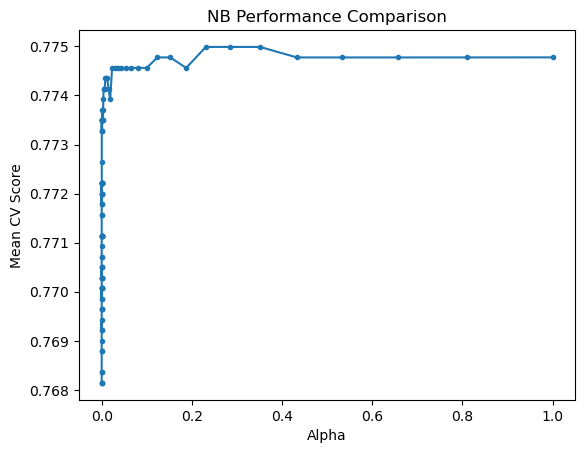

In [111]:
results_NB = pd.DataFrame(modelC_grid.cv_results_['params'])
results_NB['test_score'] = modelC_grid.cv_results_['mean_test_score']
plt.plot(results_NB['alpha'], results_NB['test_score'], marker = '.')    
plt.xlabel('Alpha')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

For approach 2:

In [121]:
param_grid2_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [122]:
model_grid = GridSearchCV(estimator = model, 
                            param_grid = param_grid2_nb, 
                            verbose = 1, 
                            cv = cv_method,
                            scoring = 'accuracy')
model_grid.fit(X_new_train, y_train)
print('--------------------------------------------------------')
print('Best Estimator: ', model_grid.best_estimator_)
print('--------------------------------------------------------')
print('Higest Accuracy Score: ', model_grid.best_score_)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
--------------------------------------------------------
Best Estimator:  GaussianNB(var_smoothing=1.0)
--------------------------------------------------------
Higest Accuracy Score:  0.7777654107236103


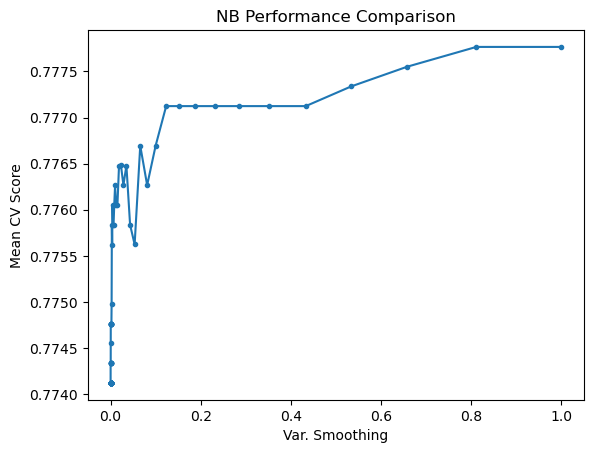

In [123]:
results_NB = pd.DataFrame(model_grid.cv_results_['params'])
results_NB['test_score'] = model_grid.cv_results_['mean_test_score']
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

## Best NB Model

In [114]:
model_best = CategoricalNB(alpha=0.3511191734215131)
clf_best = model_best.fit(X_train1_fitted, y_train)
print_results(model_best, clf_best, X_test1_fitted, y_test1)
# slightly worse after tuning LOL

Classes:  [0 1]
Class Log Priors:  [-0.70023712 -0.68610715]
--------------------------------------------------------
Accuracy Score:  0.7575757575757576
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       102
           1       0.79      0.78      0.78       129

    accuracy                           0.76       231
   macro avg       0.75      0.76      0.75       231
weighted avg       0.76      0.76      0.76       231

